In [3]:
from utilities.barn_enviroment import Barn

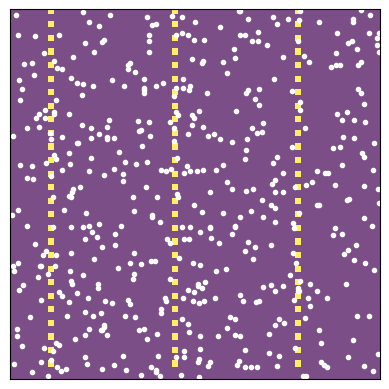

In [4]:
barn = Barn((300, 300), 500)
barn.draw()

In [3]:
barn.step()
barn.draw()

Wandering


TypeError: 'set' object is not subscriptable

In [4]:
barn.chickens

array([[  7,  98],
       [  7,  99],
       [  7, 100],
       ...,
       [293, 198],
       [293, 199],
       [293, 200]])